# Your First Consumption-Saving Model

Consider the following **consumption-saving model**:

$$ 
\begin{aligned}
v_{t}(m_{t}) &= \max_{c_t}\frac{c^{1-\rho}}{1-\rho} + \beta \mathbb{E}_t[v_{t+1}(m_{t+1})] \\
& \text{s.t.} \\ 
a_{t}&=m_{t}-c_{t} \\
m_{t+1}&= R a_{t} + \tilde{\xi}_{t+1}\\
a_t&\geq 0\\
\end{aligned}$$

where

$$ 
\begin{aligned}
\log\xi_{t+1} \sim \mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned} $$

In the **last period** everything is consumed such that

$$ 
\begin{aligned}
v_{T}(m_{T}) = \frac{m_T^{1-\rho}}{1-\rho} 
\end{aligned} $$

To **solve this model using the ConSav package** we need to define the following functions:

1. `setup(model)`: Set baseline parameters
2. `allocate(model)`: Create grids and allocate solution and simulation memory
3. `solve(model)`: Solve the model
4. `simulate(model)`: Simulate the model (not done in this notebook)

Then we collect all of these functions as methods in a **class**.

## Numerical integration

**General problem:** How can we calculate 

$$\mathbb{E}(f(x))=\int f(x)g(x)dx$$

where 

1. $f:\mathbb{R}\rightarrow\mathbb{R}$ is some function
2. $g(x)$ is the probability distribution function (PDF) for $x$ and $G(x)$ is the CDF

**General solution:** Turn it into a discrete sum

$$\mathbb{E}(f(x))\approx\sum_{i=1}^{S}\omega_{i}f(x_{i})$$

**Gauss-Hermite:** Specific clever way of choosing the $\omega_i$'s and $x_i$'s. 

Provided for a log-normal variable by ConSav in `normal_gauss_hermite`.

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from numba import njit, prange
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# consav, install with pip install git+https://github.com/NumEconCopenhagen/ConsumptionSaving
from consav import ModelClass, jit, linear_interp, golden_section_search
from consav.misc import elapsed, nonlinspace, normal_gauss_hermite

# Components

The **setup** function:

In [2]:
def setup(model):
    """ set baseline parameters"""
        
    par = model.par

    # a. define list of non-float scalars
    model.not_float_list = ['T','Nxi','Nm','simN']
    
    # this ensures that e.g. rho = 2 raises an error instead of rho being inferred as an integer
    
    # b. parameters
    par.T = 100 # number of periods
    par.rho = 2.0 # CRRA parameter
    par.beta = 0.96 # discount factor
    par.sigma_xi = 0.1 # std. of transitory shock
    par.Nxi  = 8 # number of quadrature points for xi
    par.R = 1.04 # return factor
    par.Nm = 100 # number of nodes in grid for m
    par.m_min = 1e-6 # minimum point in grid for m
    par.m_max = 20.0 # maximum point in grid for m
    par.m_phi = 1.3 # curvature parameter for grid for m
    par.simN = 10_000 # number of persons in simulation

The **allocate** function:

In [3]:
def allocate(model):
    """ allocate model, i.e. create grids and allocate solution and simluation arrays """
    
    par = model.par
    sol = model.sol
    sim = model.sim   
    
    # a. grids
    par.grid_m = nonlinspace(par.m_min,par.m_max,par.Nm,par.m_phi) # non-equally spaced grid
    par.xi, par.xi_w = normal_gauss_hermite(sigma=par.sigma_xi,n=par.Nxi) # nodes and weights using Gauss-Hermite
    
    # b. solution
    sol.c = np.zeros((par.T,par.Nm))
    sol.v = np.zeros((par.T,par.Nm))
    
    # c. simulation
    sim.m = np.zeros((par.T,par.simN))
    sim.c = np.zeros((par.T,par.simN))
    sim.a = np.zeros((par.T,par.simN))
    sim.xi = np.zeros((par.T,par.simN))

The **solve** function:

In [4]:
def value_of_choice(c,t,m,model):
    """ value of choice """
    
    par = model.par
    sol = model.sol
    
    if c <= 0: return -np.inf
    
    # a. end-of-period assets
    a = m - c
    
    # b. next-period cash-on
    m_plus = par.R*a + par.xi
    
    # c. continuation value
    v_plus = np.zeros(m_plus.size)
    linear_interp.interp_1d_vec(par.grid_m,sol.v[t+1,:],m_plus,v_plus)
            
    # d. value-of-choice
    total = c**(1-par.rho)/(1-par.rho) + par.beta*np.sum(par.xi_w*v_plus)
    return total    
    
def solve(model):
    """ solve model with vfi """
    
    par = model.par
    sol = model.sol
    
    t0 = time.time()
    
    # a. last-period
    sol.c[-1,:] = par.grid_m
    sol.v[-1,:]= par.grid_m**(1-par.rho)/(1-par.rho) 
    
    # b. backwards induction
    for t in reversed(range(par.T-1)):
        for i_m,m in enumerate(par.grid_m):

            obj = lambda c: -value_of_choice(c,t,m,model)
            result = optimize.minimize_scalar(obj,method='bounded',bounds=(0,m))

            sol.c[t,i_m] = result.x
            sol.v[t,i_m]= -result.fun 
    
    print(f'model solved in {elapsed(t0)}')

The **simulate** function:

In [5]:
def simulate(model,seed=1917):
    """ simulate model """
    
    par = model.par
    sol = model.sol
    sim = model.sim
    
    t0 = time.time()
    
    # a. shocks
    if not seed is None: np.random.seed(seed)
    sim.xi[:,:] = np.exp(np.random.normal(-0.5*par.sigma_xi**2,par.sigma_xi,size=(par.T,par.simN)))
    
    # a. initial cash-on-hand
    sim.m[0,:] = sim.xi[0,:] 
    
    # c. time loop
    for t in range(par.T):
        
        # i. consumption
        linear_interp.interp_1d_vec(par.grid_m,sol.c[t],sim.m[t,:],sim.c[t,:])

        # ii. end-of-period assets
        sim.a[t,:] = sim.m[t,:]-sim.c[t,:]

        # iii. next-period
        if t < par.T-1: sim.m[t+1] = par.R*sim.a[t,:] + sim.xi[t+1,:]
            
    print(f'model simulated in {elapsed(t0)}')            

# Class

**Define class:**

In [6]:
class ConsumptionSavingModelClass(ModelClass):
    
    setup = setup
    allocate = allocate
    solve = solve
    simulate = simulate

**Construct instance:**

In [7]:
model = ConsumptionSavingModelClass(name='myfirstconsavmodel')

**Check the type inference:**

In [8]:
print(model)

Modelclass: ConsumptionSavingModelClass

Parameters:
 T = 100 [int]
 rho = 2.0 [float]
 beta = 0.96 [float]
 sigma_xi = 0.1 [float]
 Nxi = 8 [int]
 R = 1.04 [float]
 Nm = 100 [int]
 m_min = 1e-06 [float]
 m_max = 20.0 [float]
 m_phi = 1.3 [float]
 simN = 10000 [int]
 grid_m = ndarray with shape = (100,) [dtype: float64]
 xi = ndarray with shape = (8,) [dtype: float64]
 xi_w = ndarray with shape = (8,) [dtype: float64]
memory, gb: 0.0

Solution:
 c = ndarray with shape = (100, 100) [dtype: float64]
 v = ndarray with shape = (100, 100) [dtype: float64]
memory, gb: 0.0

Simulation:
 m = ndarray with shape = (100, 10000) [dtype: float64]
 c = ndarray with shape = (100, 10000) [dtype: float64]
 a = ndarray with shape = (100, 10000) [dtype: float64]
 xi = ndarray with shape = (100, 10000) [dtype: float64]
memory, gb: 0.0



> **Note:** When initializing the model with `ConsumptionSainvgModelClass()` the `setup()` and `allocate()` methods are called, and the types of all variables in `.par`, `.sol` and `.sim` are inferred. This types and the number of dimensions of numpy arrays must not be changed afterwards.

**Solve:**

In [9]:
model.solve()

model solved in 4.6 secs


**Simulate:**

In [10]:
model.simulate()

model simulated in 0.1 secs


In [11]:
par = model.par
sol = model.sol
sim = model.sim

**Consumption functions:**

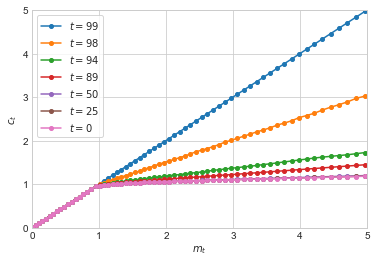

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for t in [par.T-1, par.T-2, par.T-6, par.T-11, 50, 25, 0]:
    if t >= 0: ax.plot(par.grid_m,sol.c[t,:],'-o',ms=4,label=f'$t = {t}$')

# layout
ax.legend(frameon=True)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$');

**Time profile of end-of-period assets:**

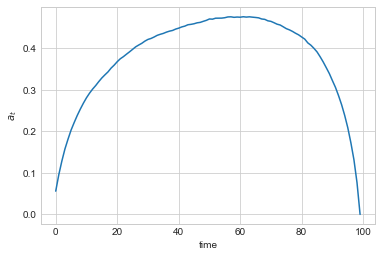

In [13]:
par = model.par
sol = model.sol

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(par.T),np.mean(sim.a,axis=1))

# layout
ax.set_xlabel('time')
ax.set_ylabel('$a_t$');

**Histograms of end-of-period assets:**

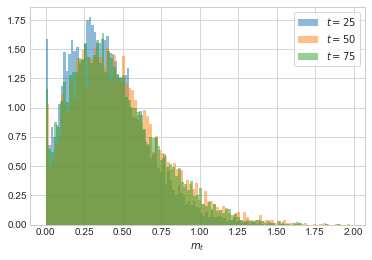

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for t in [25,50,75]:
    if t < par.T-1: ax.hist(sim.a[t,:],bins=100,alpha=0.5,label=f'$t = {t}$',density=True)

# layout
ax.legend(frameon=True)
ax.set_xlabel('$m_t$');

# Inherited methods

**1. Keyword arguments updated with .par:**

In [15]:
low_beta = ConsumptionSavingModelClass(name='baseline',beta=0.9)
print(low_beta.par.beta)

0.9


**2. Save/load:**

In [16]:
model.save() # see data\myfirstconsavmodel*

These objects are saved:

1. Everything in `.par`, `.sol` and `.sim`
2. `.not_float_list = []`
3. Everything listed in `.savelist = []`

In [17]:
model_loaded = ConsumptionSavingModelClass(name='myfirstconsavmodel',load=True)

**3. copy**

In [18]:
model_copy = model_loaded.copy()
print(f'name: {model_copy.name}\n')
print(model_copy)

name: myfirstconsavmodel_copy

Modelclass: ConsumptionSavingModelClass

Parameters:
 T = 100 [int]
 rho = 2.0 [float]
 beta = 0.96 [float]
 sigma_xi = 0.1 [float]
 Nxi = 8 [int]
 R = 1.04 [float]
 Nm = 100 [int]
 m_min = 1e-06 [float]
 m_max = 20.0 [float]
 m_phi = 1.3 [float]
 simN = 10000 [int]
 grid_m = ndarray with shape = (100,) [dtype: float64]
 xi = ndarray with shape = (8,) [dtype: float64]
 xi_w = ndarray with shape = (8,) [dtype: float64]
memory, gb: 0.0

Solution:
 c = ndarray with shape = (100, 100) [dtype: float64]
 v = ndarray with shape = (100, 100) [dtype: float64]
memory, gb: 0.0

Simulation:
 m = ndarray with shape = (100, 10000) [dtype: float64]
 c = ndarray with shape = (100, 10000) [dtype: float64]
 a = ndarray with shape = (100, 10000) [dtype: float64]
 xi = ndarray with shape = (100, 10000) [dtype: float64]
memory, gb: 0.0



# Numba

The beauty of the **ModelClass** from **ConSav** is that it is [Numba]((http://numba.pydata.org/)) prepared, so it is very easy to call numba optimized functions. Numba automatically convert Python and NumPy code into fast machine code. Specifically, this is done for all functions preceded (decorated) with ``@njit`` or ``@njit(parallel=True)`` when parallization is used.

> For more info about **Numba** see [here](https://numeconcopenhagen.netlify.com/lectures/The_need_for_speed#Numba).

**New functions:**

In [23]:
@njit
def value_of_choice_jit(c,t,m,sol,par):
            
    # a. end-of-period assets
    a = m - c
    
    # b. next-period cash-on
    m_plus = par.R*a + par.xi
    
    # c. continuation value
    v_plus = np.zeros(m_plus.size)
    linear_interp.interp_1d_vec(par.grid_m,sol.v[t+1,:],m_plus,v_plus)
            
    # d. value-of-choice
    total = c**(1-par.rho)/(1-par.rho) + par.beta*np.sum(par.xi_w*v_plus)
    return -total    

@njit(parallel=True)
def solve_(t,sol,par):
    
    c = sol.c[t]
    v = sol.v[t]
    
    for i_m in prange(par.Nm):
        m = par.grid_m[i_m]
        c[i_m] = golden_section_search.optimizer(value_of_choice_jit,1e-8,m,args=(t,m,sol,par))
        v[i_m] = -value_of_choice_jit(c[i_m],t,m,sol,par)
        
def solve_jit(model):
    
    par = model.par
    sol = model.sol
    
    t0 = time.time()
    
    # a. last-period
    sol.c[-1,:] = par.grid_m
    sol.v[-1,:]= par.grid_m**(1-par.rho)/(1-par.rho) 
    
    # b. backwards induction
    with jit(model) as model_jit:
        for t in reversed(range(par.T-1)):
            solve_(t,model_jit.sol,model_jit.par)
        
    print(f'model solved in {elapsed(t0)}')        

**New model class:**

In [24]:
class ConsumptionSavingModelClass_jit(ModelClass):
    
    setup = setup
    allocate = allocate
    solve = solve_jit
    simulate = simulate

**Solve the model with numba:**

1. On the first run a few seconds is spend on analyzing the code
2. From the second run onwards it is really fast

In [25]:
model_jit = ConsumptionSavingModelClass_jit('jit')
for _ in range(3):
    model_jit.solve()

model solved in 2.3 secs
model solved in 0.2 secs
model solved in 0.2 secs


**Compare solutions:**

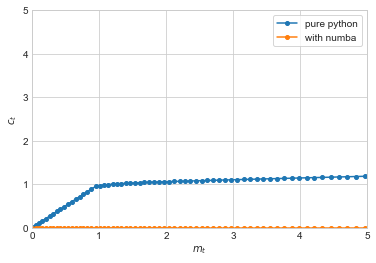

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par.grid_m,model.sol.c[0,:],'-o',ms=4,label=f'pure python')
ax.plot(par.grid_m,model_jit.sol.c[0,:],'-o',ms=4,label=f'with numba')

# layout
ax.legend(frameon=True)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$');